In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def plot_posterior_predictive(ppc, 
                              observations,
                              fun1 = lambda x: np.mean(x, axis = 1), 
                              fun2 = lambda x: np.mean(x),
                              xlab = "mean(x)",
                             title = "Posterior predictive of mean"):
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist(fun1(ppc['obs']), bins=20, alpha=0.5)
    ax.axvline(fun2(observations))
    ax.set(title=title, xlabel=xlab, ylabel='Frequency');

# PBMC 68k

In [3]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+\\/]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

In [4]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc68k_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc_68k_normal_logfcs.feather')

## Naive CD8+ vs. Naive CD4+

In [5]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

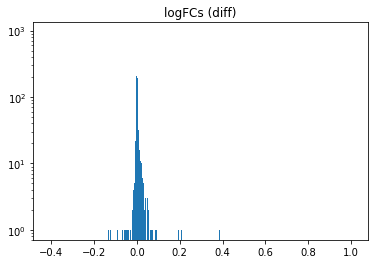

In [6]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

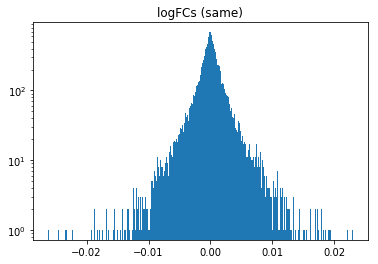

In [7]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

In [9]:
def zvalue(value, sd=1, mu=0):
    """
    Calculate the z-value for a normal distribution. By default standard normal.
    """
    return (value - mu) / tt.sqrt(2. * sd ** 2.)

def cdf(mu, sd, value):
    z = zvalue(value, mu=mu, sd=sd)
    return tt.erfc(-z / tt.sqrt(2.))/2.

def run_model(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
        #pos_component = pm.Deterministic('pos_component', tt.abs_(pm.Normal('pos_x', mu = mu_pos, sd = sd)))
        #neg_component = pm.Deterministic('neg_component', tt.abs_(pm.Normal('neg_x', mu = mu_neg, sd = sd)))
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

#         pm.Mixture('obs',
#                   w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob), de_prob * down_prob]),
#                   comp_dists = [null_component, pos_component, neg_component],
#                   observed = observations)

        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob) * (1.-cdf_pos), de_prob * down_prob * cdf_neg,
                                   de_prob * (1.-down_prob) * cdf_pos, de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [null_component, pos_component, neg_component, pos_component_abs,
                               neg_component_abs],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})


In [16]:
def bf_comparison(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        
        # Prior model probability
        pi = [0.3, 0.7]
        
        # Indicator variable for true model selected
        true_model = pm.Bernoulli('true_model', pi[1])
        
        ## MODEL 1
        
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

        model1 = pm.Mixture.dist(
                  w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob) * (1.-cdf_pos), de_prob * down_prob * cdf_neg,
                                   de_prob * (1.-down_prob) * cdf_pos, de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [null_component, pos_component, neg_component, pos_component_abs,
                               neg_component_abs])
    
        ## MODEL 2
        
        # Probability of being a DE gene
        de_prob2 = pm.Uniform('de_prob2', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob2 = pm.Beta('down_prob2', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null2 = pm.Gamma('mu_null2', alpha = 1., beta = 1.)
        sd_null2 = pm.Gamma('sd_null2', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos2 = pm.Lognormal('mu_pos2', mu = 0., sd = 1.)
        mu_neg2 = pm.Lognormal('mu_neg2', mu = 0., sd = 1.)

        sd2 = pm.Gamma('sd2', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null2',
                 mu = mu_null2,
                 sd = sd_null2,
                 observed = nulls)

        null_component2 = pm.Normal.dist(mu = mu_null2,
                                      sd = sd_null2)
        
        pos_component2 = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos2, sd=sd2)
        neg_component2 = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg2, sd=sd2)
        
        model2 = pm.Mixture.dist(
            w = tt.as_tensor([(1.-de_prob2), de_prob2 * (1.-down_prob2), de_prob2 * down_prob2]),
          comp_dists = [null_component2, pos_component2, neg_component2])
        
        ## MODEL COMPARISON
        
        Ylike = pm.DensityDist('Ylike',
            lambda value: pm.math.switch(true_model, 
                model1.logp(value), 
                model1.logp(value)
            ),
            observed=observations)
        
        step1 = pm.step_methods.Metropolis(vars=[true_model, sd2, mu_neg2, mu_pos2, sd_null2, mu_null2, down_prob2, de_prob2, sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob])

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4, step = [step1])
        #ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return(trace)

In [101]:
x = cdf(-0.2, 1, 0)
x.eval()

array(0.55623146)

In [32]:
with pm.Model() as model:
    x = pm.Normal('hi', mu=2., sd=1.)
    x2 = pm.Normal('hi3')
    y = pm.Deterministic('hi2', x + 2)
    z = pm.Normal.dist(mu=2., sd=1.)
    z3 = pm.Mixture.dist(w = [0.5, 0.5], comp_dists=[z, z])

print(type(x2))
print(type(x))
print(type(y))
print(type(z))
print(type(z3))

pm.Normal.dist(mu = 2., sd = 1.).logp(2).eval()
z3.logp(3).eval()


<class 'pymc3.model.FreeRV'>
<class 'pymc3.model.FreeRV'>
<class 'theano.tensor.var.TensorVariable'>
<class 'pymc3.distributions.continuous.Normal'>
<class 'pymc3.distributions.mixture.Mixture'>


array([-1.41893853])

In [58]:
bf_trace_old = bf_trace

In [17]:
bf_trace = bf_comparison(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [de_prob]
>Metropolis: [down_prob]
>Metropolis: [mu_null]
>Metropolis: [sd_null]
>Metropolis: [mu_pos]
>Metropolis: [mu_neg]
>Metropolis: [sd]
>Metropolis: [de_prob2]
>Metropolis: [down_prob2]
>Metropolis: [mu_null2]
>Metropolis: [sd_null2]
>Metropolis: [mu_pos2]
>Metropolis: [mu_neg2]
>Metropolis: [sd2]
>Metropolis: [true_model]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:24<00:00, 94.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f23278080>,
      dtype=object)

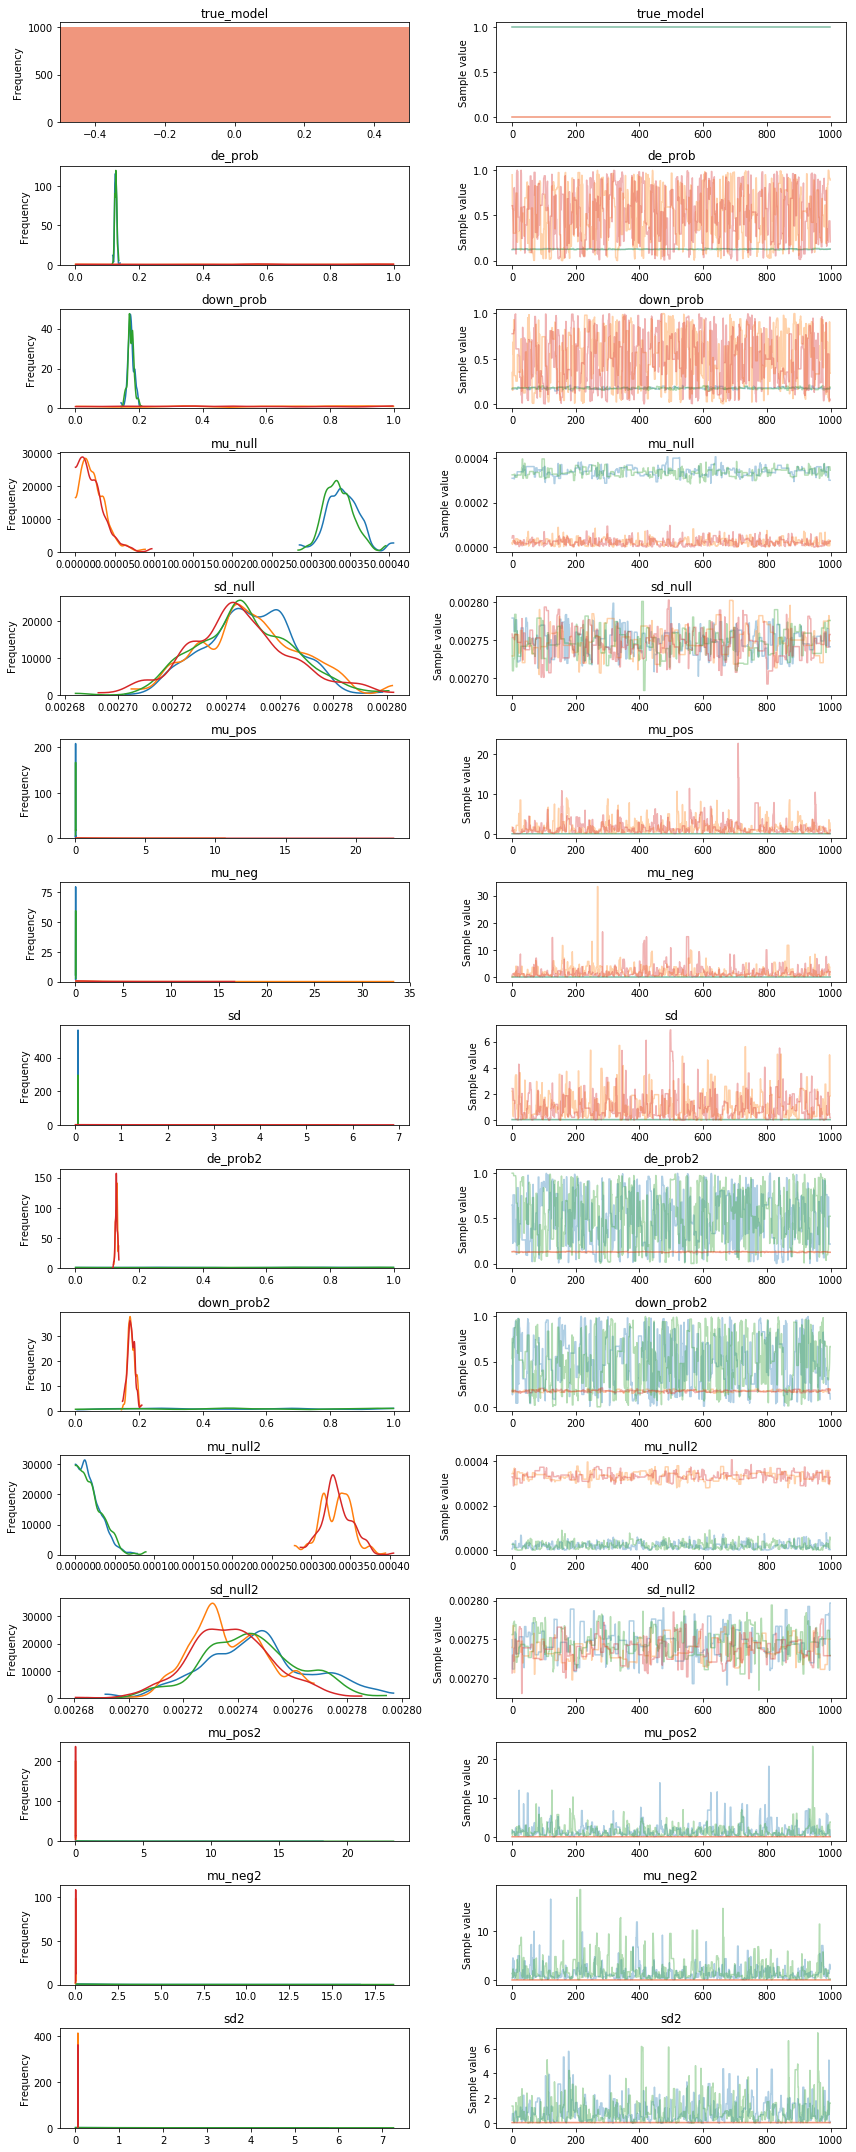

In [11]:
pm.traceplot(bf_trace)

In [13]:
pm.summary(bf_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
true_model,0.500000,0.500000,5.000000e-02,0.000000e+00,1.000000,NaN,inf
de_prob,0.320154,0.282459,2.006845e-02,8.746900e-02,0.979667,4.181013,1.476218
down_prob,0.342916,0.264696,1.804163e-02,1.113012e-01,0.998032,4.953617,1.383183
mu_null,0.000180,0.000159,1.579786e-05,8.380636e-08,0.000363,2.022744,10.268572
sd_null,0.002747,0.000018,7.736119e-07,2.716301e-03,0.002783,480.514806,1.005074
mu_pos,0.779533,1.421226,8.623906e-02,2.254780e-02,3.402619,7.169993,1.229964
mu_neg,0.913680,1.863875,1.046093e-01,7.513356e-03,3.908442,9.238619,1.181073
sd,0.555173,0.862158,5.429206e-02,8.729715e-03,2.306440,6.120357,1.286840
de_prob2,0.321017,0.281096,2.035279e-02,8.831224e-02,0.978546,4.148840,1.477105
down_prob2,0.339162,0.261472,1.776775e-02,1.139225e-01,0.992909,5.172381,1.366232


In [48]:
p = bf_trace['true_model'].mean()  
BF = ((1-p)/p) * (0.5/0.5)  

BF

inf

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dd564a1d0>,
      dtype=object)

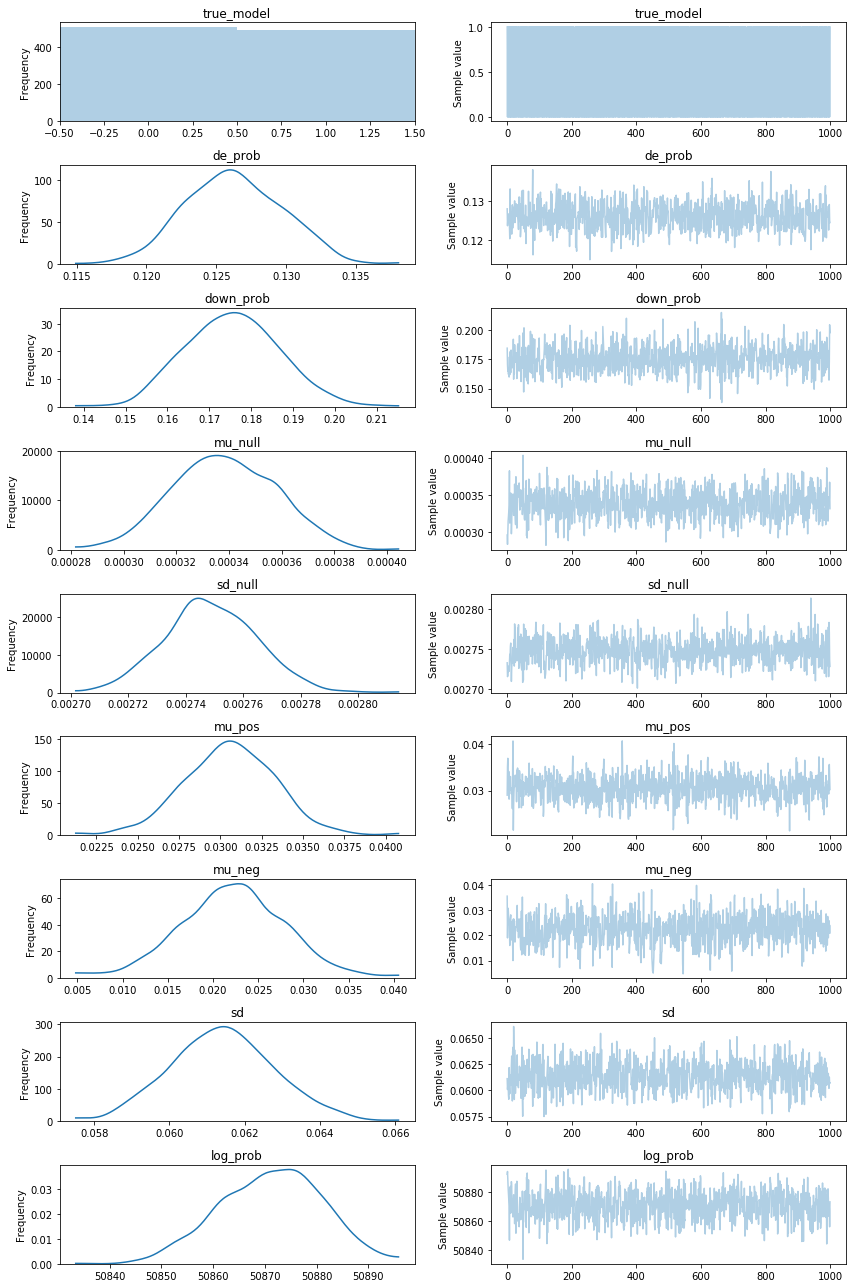

In [39]:
pm.plots.traceplot(bf_trace)

In [41]:
pm.summary(bf_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
true_model,0.491000,0.499919,7.495999e-03,0.000000,1.000000
de_prob,0.126224,0.003440,1.176347e-04,0.120317,0.133117
down_prob,0.175440,0.011201,3.715793e-04,0.154830,0.196748
mu_null,0.000338,0.000019,6.299605e-07,0.000302,0.000375
sd_null,0.002748,0.000016,5.214764e-07,0.002719,0.002781
mu_pos,0.030527,0.002740,8.082222e-05,0.025780,0.036600
mu_neg,0.022111,0.005827,2.043215e-04,0.010591,0.033307
sd,0.061396,0.001354,4.286730e-05,0.058718,0.063954
log_prob,50871.050540,9.787164,3.220441e-01,50850.608146,50887.792833


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 1000/1000 [00:22<00:00, 45.29it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f970225f898>,
      dtype=object)

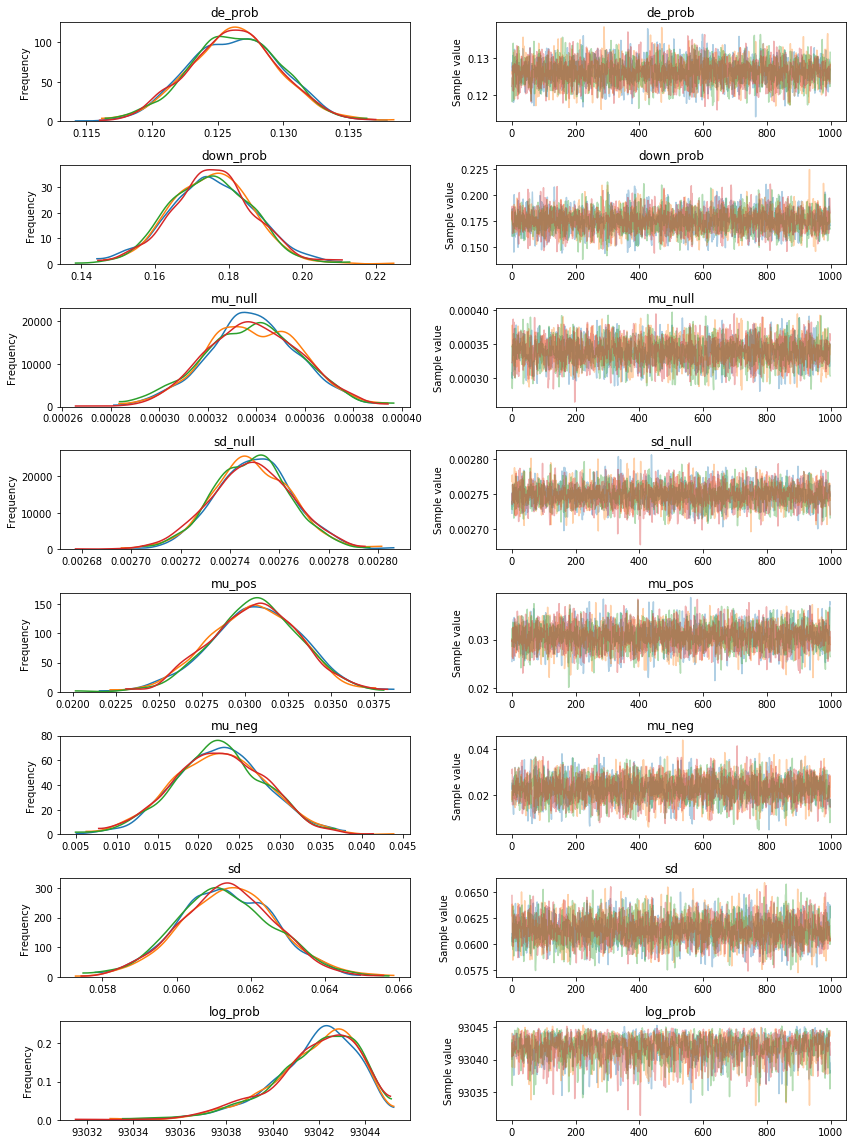

In [105]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:21<00:00, 94.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96efedce80>,
      dtype=object)

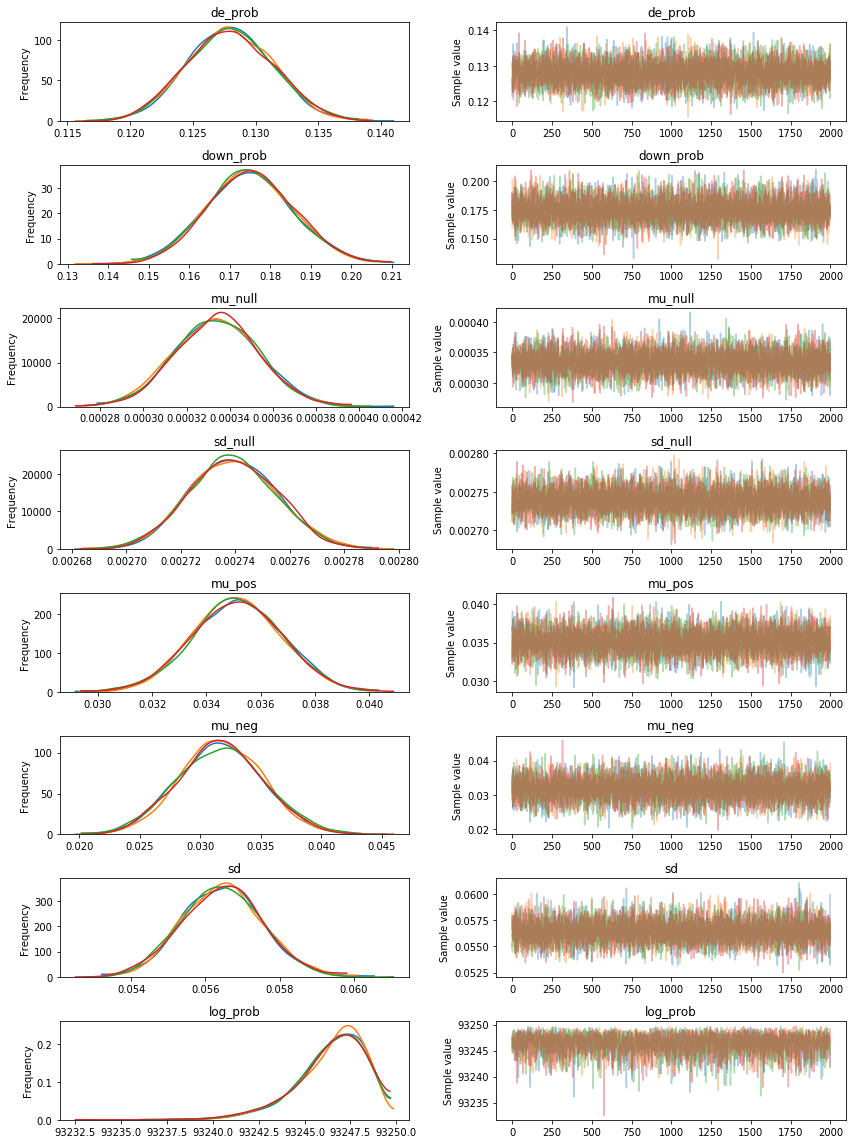

In [100]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(pbmc_res['trace'])

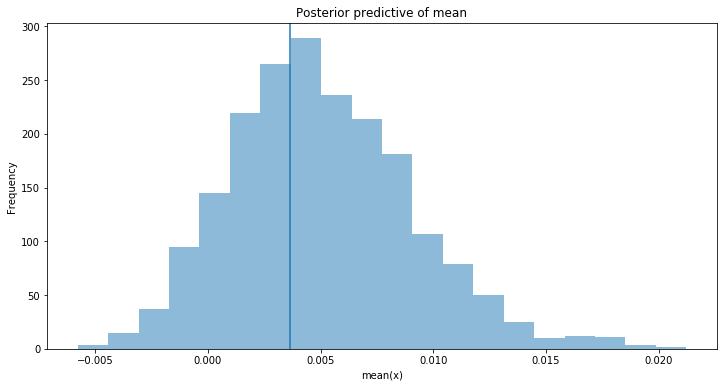

In [91]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

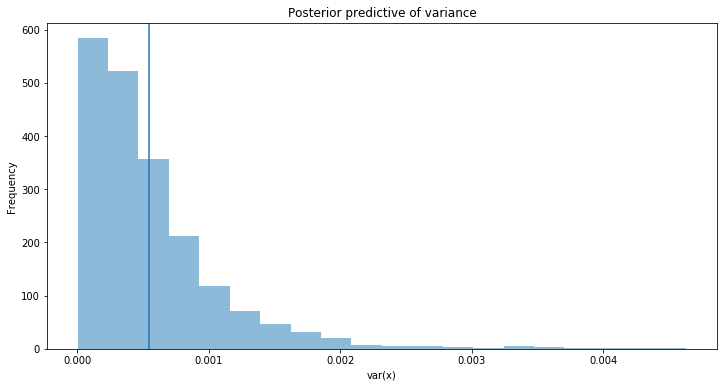

In [92]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

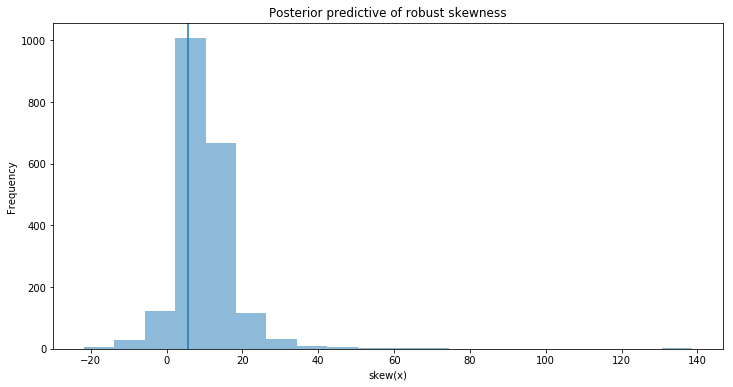

In [93]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

These posterior predictive checks provide support that our model parameters approximately recapitulate the input data. 

In [112]:
sce_markers.head(5)

,cluster,Top,FDR,logFC.B,logFC.B..dendritic..T,logFC.CD8.,logFC.Megakaryocytes,logFC.Memory.and.Reg.T,logFC.Monocytes.and.dendritic,logFC.Naive.CD4.,logFC.Naive.CD8.,logFC.NK,Gene,logFC.Activated.CD8.,Symbol
0,Activated CD8+,1,0.0,3.308510,3.223352,1.503564,3.205693,3.292188,3.172427,3.364977,3.299910,-0.552253,ENSG00000105374,NaN,NKG7
1,Activated CD8+,1,0.0,3.431245,3.422709,0.947874,0.445943,3.202385,3.417239,3.447641,3.238764,1.621012,ENSG00000161570,NaN,CCL5
2,Activated CD8+,1,0.0,3.650582,3.606749,2.619801,3.553104,3.633361,3.577226,3.706064,3.682098,-0.610140,ENSG00000115523,NaN,GNLY
3,Activated CD8+,1,0.0,1.410254,1.370745,0.349305,1.323605,0.276273,1.374793,0.458424,0.343195,1.418768,ENSG00000167286,NaN,CD3D
4,Activated CD8+,1,0.0,1.351643,1.357580,1.267222,1.291606,1.358415,1.348757,1.363011,1.354460,-0.079288,ENSG00000137441,NaN,FGFBP2


## CD8+ vs. Naive CD4+

In [11]:
class1 = "B"
class2 = "CD8+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

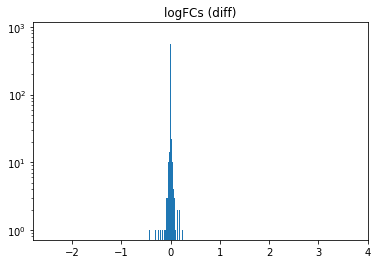

In [12]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

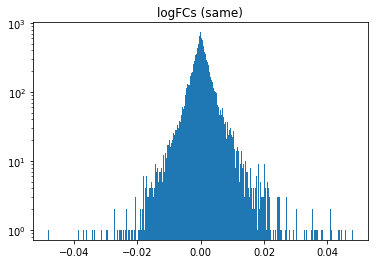

In [13]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 1000/1000 [00:20<00:00, 48.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b1efe1278>,
      dtype=object)

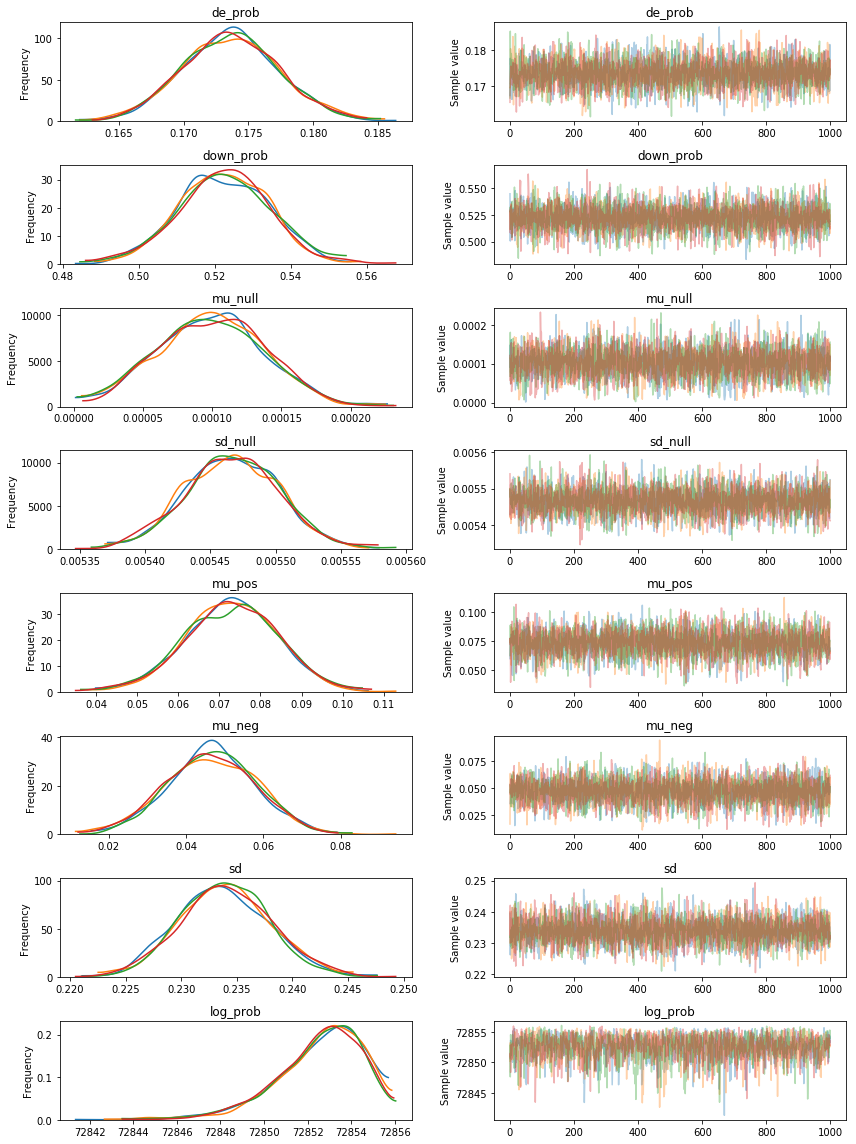

In [14]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:05<00:00, 20.51draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:21<00:00, 45.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f972d1442b0>,
      dtype=object)

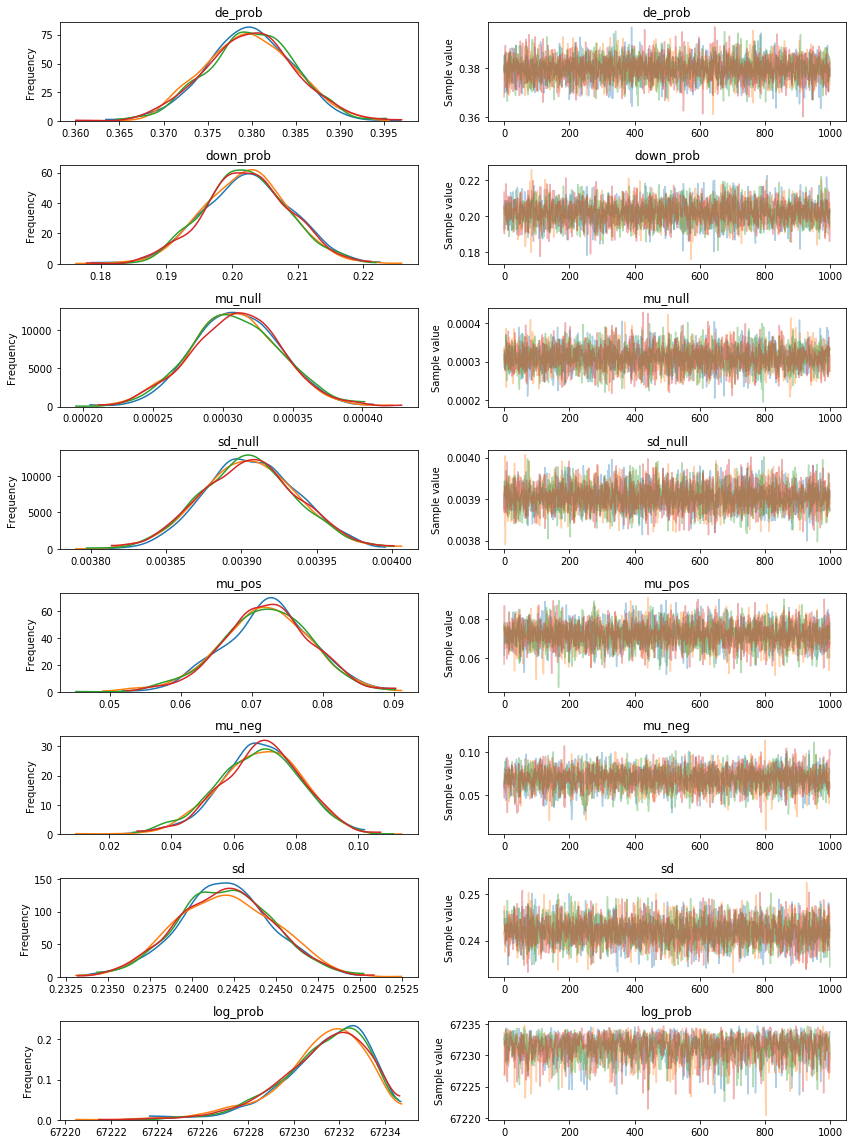

In [118]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

# HGSC high confidence

We'll perform the same analysis, but on the HGSC data that has been generated locally.

In [120]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_normal_logfcs.feather')

In [121]:
sce_markers.head(5)

,cluster,Top,FDR,logFC.Cancer.cell,logFC.CD4.T.cells,logFC.Cytotoxic.T.cells,logFC.Endothelial.cells,logFC.Fibroblast.Myofibroblast,logFC.Monocyte.Macrophage,logFC.NK.cells,Gene,logFC.B.cells,Symbol
0,B cells,1,6.198315e-314,-3.818161,-0.147442,-0.026770,0.033721,-0.003174,0.025682,-0.110829,ENSG00000101443,NaN,WFDC2
1,B cells,1,1.078661e-261,-2.433924,0.014814,0.015954,-0.907922,-2.140297,-2.931242,0.032732,ENSG00000101439,NaN,CST3
2,B cells,1,6.216684e-237,0.006792,0.014299,-1.399068,-0.000536,0.000776,-0.000304,-0.003335,ENSG00000153563,NaN,CD8A
3,B cells,1,2.571330e-209,-0.004717,-1.338659,-1.185269,-0.012082,0.005803,-0.011113,-0.153698,ENSG00000198851,NaN,CD3E
4,B cells,1,5.002838e-76,-0.505529,1.871738,1.994309,1.619378,3.544489,-1.732128,2.582217,ENSG00000019582,NaN,CD74


## CD4+ vs. CD8+ T cells

In [122]:
class1 = "CD4 T cells"
class2 = "Cytotoxic T cells"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

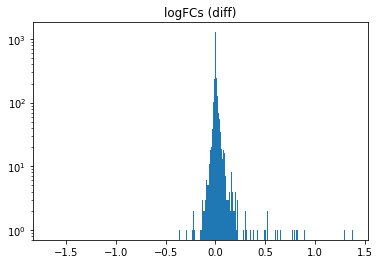

In [108]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

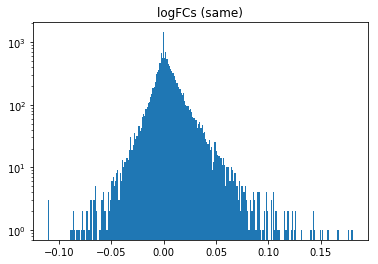

In [109]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 1000/1000 [00:29<00:00, 33.68it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9700ac27b8>,
      dtype=object)

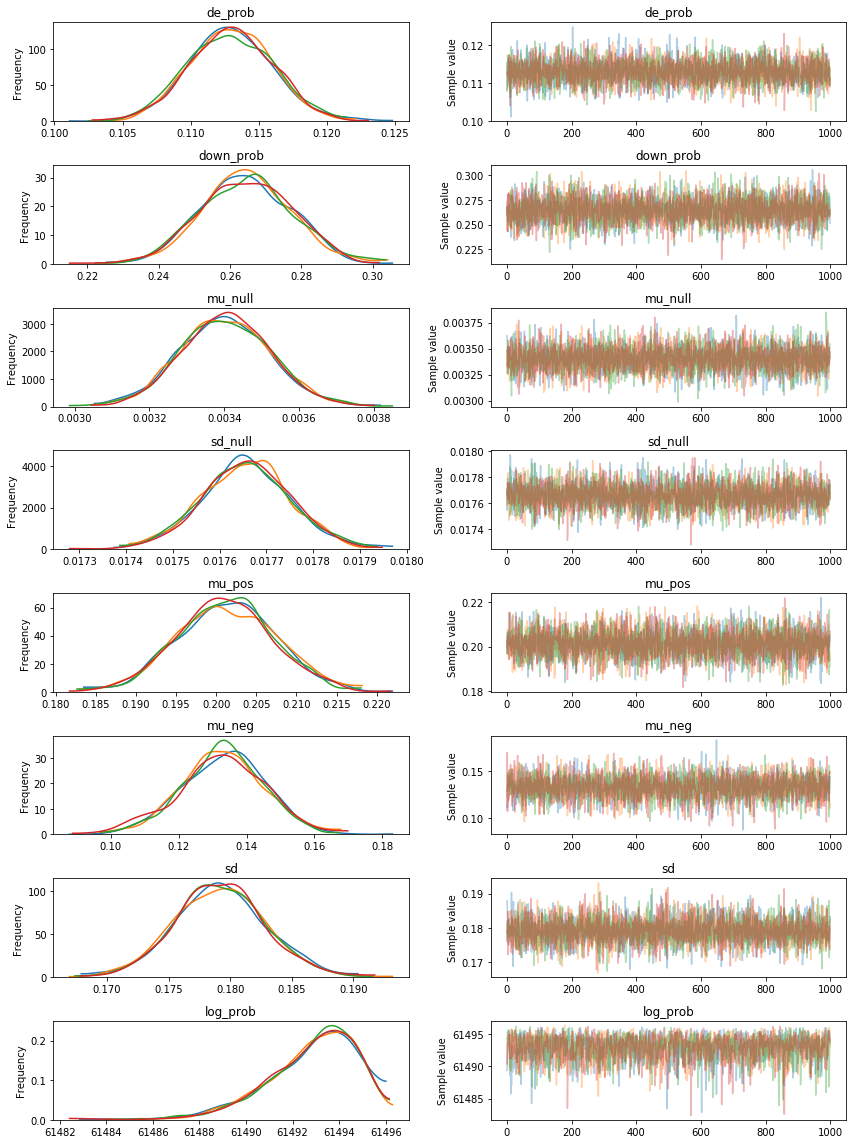

In [110]:
hgsc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(hgsc_res['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:20<00:00, 96.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f973a1d2a58>,
      dtype=object)

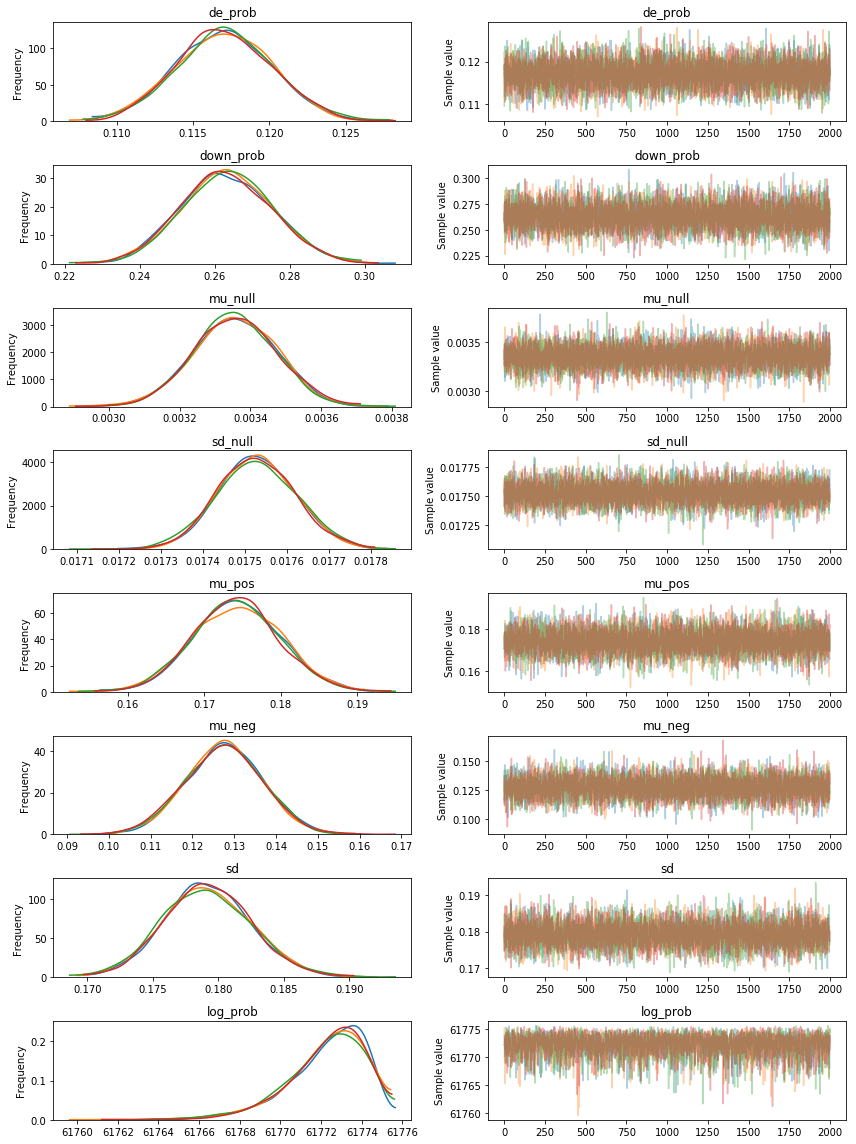

In [21]:
hgsc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res['trace'])

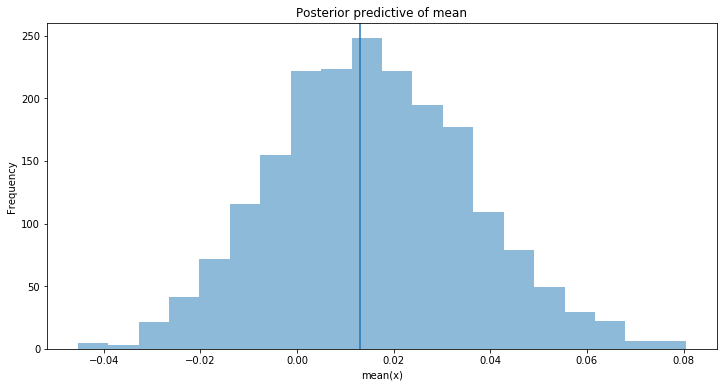

In [22]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

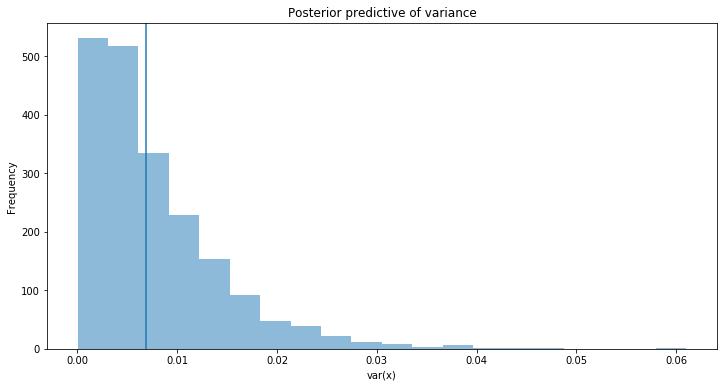

In [23]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

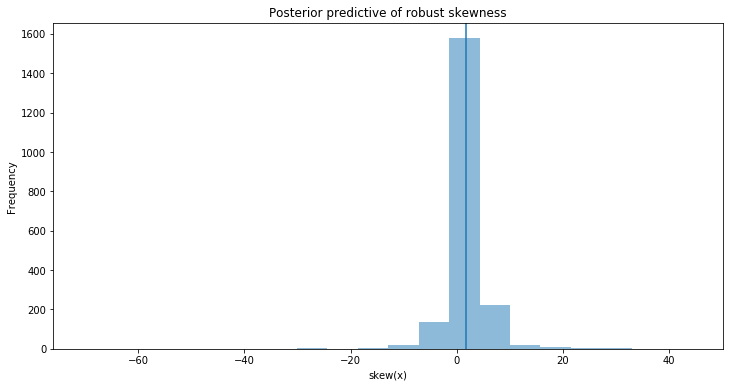

In [24]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

Note that the $\mu_{pos}$ and $\mu_{neg}$ values are higher in this comparison than in the PBMC dataset. This could be due to a few reasons:

* Naive CD4+ and CD8+ T cells differ less than CD4+ and CD8+ T cells
* The 90\% probability threshold set for CellAssign predictions in the HGSC dataset filters out cells that may be assigned with less certainty to CD4+ or CD8+

## Cancer cells vs. fibroblasts

Cancer cells and fibroblasts should be fairly phenotypically distinct -- we can use this comparison as an example of the other end of the spectrum for these parameters.

In [123]:
class1 = "Monocyte/Macrophage"
class2 = "CD4 T cells"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

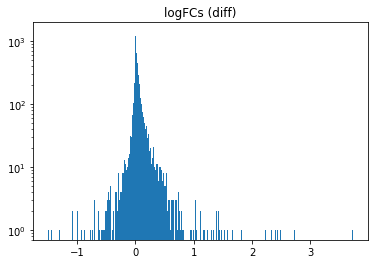

In [124]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

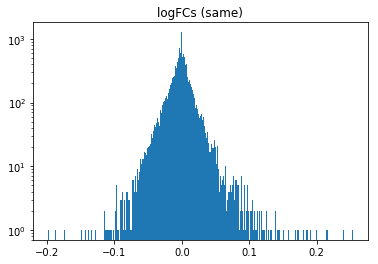

In [125]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:53<00:00, 37.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9739e4a4e0>,
      dtype=object)

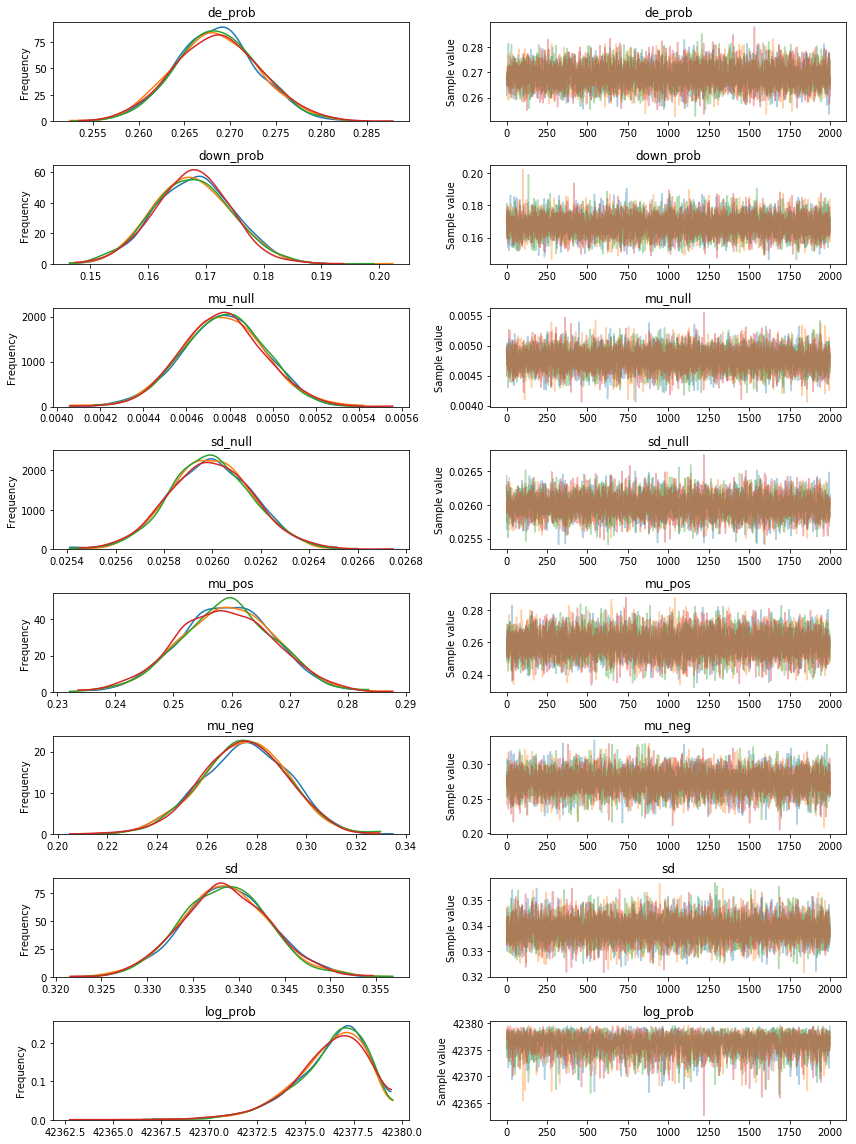

In [126]:
hgsc_res2 = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res2['trace'])

As is clear, `de_prob`, $\mu_{pos}$, and $\mu_{neg}$ are higher due to the greater difference between fibroblasts and cancer cells. 